In [1]:
import cv2
import numpy as np
import tensorflow as tf
from tensorflow.keras.datasets import mnist
from tensorflow.keras.layers import Input, Dense, Flatten, Reshape, Dropout
from tensorflow.keras.layers import Conv2D, BatchNormalization, Activation, ZeroPadding2D
from tensorflow.keras.layers import LeakyReLU, Conv2DTranspose, Embedding, Concatenate
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
(x_train, y_train),(x_test, y_test) = mnist.load_data()
img_dim = x_train.shape[1] * x_train.shape[2]
img_shape = (x_train.shape[1], x_train.shape[2], 1)
print (x_train.shape, x_test.shape)

11493376/11490434 [==============================] - 0s 0us/step
(60000, 28, 28) (10000, 28, 28)


In [3]:
#scales b/w (-1, 1) 
x_train = x_train.astype('float32') / 127.5 - 1
x_test = x_test.astype('float32') / 127.5 - 1

In [4]:
latent_dim = 100
n_classes = 10

In [13]:
#Generator
noise_input = Input(shape=(latent_dim,))
label_input = Input(shape=(1,))
lx = Embedding(n_classes, 50)(label_input)
lx = Dense(49)(lx)
lx = Reshape((7, 7, 1))(lx)
nx = Dense(7*7*128)(noise_input)
nx = LeakyReLU(alpha = 0.2)(nx)
nx = Reshape((7, 7, 128))(nx)
x = Concatenate()([nx, lx])
x = Conv2DTranspose(128, (3, 3), strides=(2, 2), padding='same')(x)
x = LeakyReLU(alpha=0.2)(x)
x = Conv2DTranspose(128, (3, 3), strides=(2, 2), padding='same')(x)
x = LeakyReLU(alpha=0.2)(x)
x = Conv2D(1, (3, 3), activation='tanh', padding='same')(x)
g_model = Model([noise_input, label_input], x)
g_model.summary()

Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            [(None, 100)]        0                                            
__________________________________________________________________________________________________
input_6 (InputLayer)            [(None, 1)]          0                                            
__________________________________________________________________________________________________
dense_5 (Dense)                 (None, 6272)         633472      input_5[0][0]                    
__________________________________________________________________________________________________
embedding_2 (Embedding)         (None, 1, 50)        500         input_6[0][0]                    
____________________________________________________________________________________________

In [14]:
#Descriminator
img_input = Input(shape=img_shape)
label_input = Input(shape=(1,))
lx = Embedding(n_classes, 50)(label_input)
lx = Dense(img_shape[0]*img_shape[1])(lx)
lx = Reshape(img_shape)(lx)
x = Concatenate()([img_input, lx])
x = Conv2D(128, (3, 3), strides=(2, 2), padding='same')(x)
x = LeakyReLU(alpha=0.2)(x)
x = Conv2D(128, (3, 3), strides=(2, 2), padding='same')(x)
x = LeakyReLU(alpha=0.2)(x)
x = Flatten()(x)
x = Dropout(0.4)(x)
x = Dense(1, activation='sigmoid')(x)
d_model = Model([img_input, label_input], x)
d_model.summary()

Model: "model_4"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_8 (InputLayer)            [(None, 1)]          0                                            
__________________________________________________________________________________________________
embedding_3 (Embedding)         (None, 1, 50)        500         input_8[0][0]                    
__________________________________________________________________________________________________
dense_6 (Dense)                 (None, 1, 784)       39984       embedding_3[0][0]                
__________________________________________________________________________________________________
input_7 (InputLayer)            [(None, 28, 28, 1)]  0                                            
____________________________________________________________________________________________

In [15]:
d_model.compile(loss = 'binary_crossentropy',
            optimizer = Adam(lr=0.0002, beta_1=0.5),
            metrics = ['accuracy'])

In [16]:
#combined model -- generator+discriminator stacked 
#freeze discriminator so we can update only generator weights
gan_output = d_model([g_model.output, g_model.input[1]])
combined_model = Model(g_model.input, gan_output)
combined_model.summary()
combined_model.layers[-1].traininable = False
combined_model.compile(loss = 'binary_crossentropy',
            optimizer = Adam(lr=0.0002, beta_1=0.5),
            metrics = ['accuracy'])

Model: "model_5"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            [(None, 100)]        0                                            
__________________________________________________________________________________________________
input_6 (InputLayer)            [(None, 1)]          0                                            
__________________________________________________________________________________________________
dense_5 (Dense)                 (None, 6272)         633472      input_5[0][0]                    
__________________________________________________________________________________________________
embedding_2 (Embedding)         (None, 1, 50)        500         input_6[0][0]                    
____________________________________________________________________________________________

In [38]:
def plot_output(class_name=None):
  assert class_name is not None, 'class not found'
  noise = np.random.normal(0, 1, (25, 100))
  labels = np.ones((25))*class_name
  gen_imgs = g_model.predict([noise, labels])
  gen_imgs = 0.5 * gen_imgs + 0.5
  fig,axes = plt.subplots(5,5)
  n = 0
  for i,ax in enumerate(axes.flat):
      ax.imshow(gen_imgs[n].reshape(28,28), cmap='gray')
      n+=1
      ax.set_xticks([])
      ax.set_yticks([])
  plt.show()

In [17]:
def get_batch(batch_size):
    indexes = np.random.randint(0, x_train.shape[0], batch_size)
    xi_batch = np.expand_dims(x_train[indexes], axis=-1)
    yi_batch = y_train[indexes]
    return xi_batch, yi_batch

In [24]:
batch_size = 32
discriminator_loss = []
generator_loss = []
y_batch = np.vstack((np.ones((batch_size, 1)),np.zeros((batch_size, 1))))
for ep in range(30000):
    imgs, labels = get_batch(batch_size)
    noise = np.random.normal(0, 1, (batch_size, latent_dim))
    generated_imgs = g_model.predict([noise, labels])
    discriminator_input_1 = np.vstack((imgs, generated_imgs))
    discriminator_input_2 = np.hstack((labels, labels))
    d_loss = d_model.train_on_batch([discriminator_input_1, discriminator_input_2], y_batch)
    g_loss = combined_model.train_on_batch([noise, labels], y_batch[:batch_size])
    discriminator_loss.append(d_loss[0])
    generator_loss.append(g_loss[0])
    if ep%1000==0:
        print ("epoch:",ep," ",d_loss[0], g_loss[0])

epoch: 0   1.2979909181594849 0.1051512360572815
epoch: 1000   1.357933759689331 0.1193152517080307
epoch: 2000   1.267428994178772 0.1160704642534256
epoch: 3000   1.2924458980560303 0.10039058327674866
epoch: 4000   1.2984730005264282 0.10810618847608566
epoch: 5000   1.2578270435333252 0.10231954604387283
epoch: 6000   1.2729300260543823 0.1062953844666481
epoch: 7000   1.2979687452316284 0.0981210246682167
epoch: 8000   1.254029631614685 0.10522674024105072
epoch: 9000   1.2510513067245483 0.10342782735824585
epoch: 10000   1.2563560009002686 0.1039191335439682
epoch: 11000   1.243391990661621 0.09948617219924927
epoch: 12000   1.2382526397705078 0.10050379484891891
epoch: 13000   1.288331151008606 0.09758511930704117
epoch: 14000   1.2519562244415283 0.09477606415748596
epoch: 15000   1.2735923528671265 0.09892286360263824
epoch: 16000   1.2778290510177612 0.09590068459510803
epoch: 17000   1.2631862163543701 0.10379264503717422
epoch: 18000   1.2732104063034058 0.0963350757956504

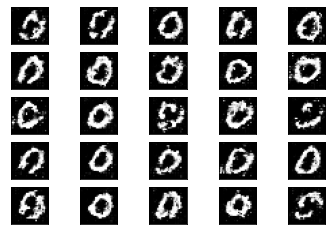

In [39]:
plot_output(class_name=0)

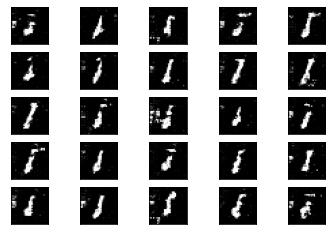

In [41]:
plot_output(class_name=1)

**References**<br>
--> https://arxiv.org/abs/1411.1784 (Conditional Generative Adversarial Nets by Mehdi Mirza, Simon Osindero)<br>
--> https://machinelearningmastery.com